# Restaurant Revenue Prediction
## Predict annual restaurant sales based on objective measurements

### Data description:

- TFI has provided a dataset with 137 restaurants in the training set, and a test set of 100000 restaurants. The data columns include the open date, location, city type, and three categories of obfuscated data: Demographic data, Real estate data, and Commercial data. The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. 

### File description:

- train.csv - the training set. Use this dataset for training your model. 
- test.csv - the test set. To deter manual "guess" predictions, Kaggle has supplemented the test set with additional "ignored" data. These are not counted in the scoring.
- sampleSubmission.csv - a sample submission file in the correct format

### Data fields:
- Id : Restaurant id. 
- Open Date : opening date for a restaurant
- City : City that the restaurant is in. Note that there are unicode in the names. 
- City Group: Type of the city. Big cities, or Other. 
- Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
- P1, P2 - P37: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
- Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

### Evaluations:

#### Root Mean Squared Error (RMSE)
- Submissions are scored on the root mean squared error. 

Import the tools for data preprocessing and EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import date, datetime
from sklearn.preprocessing import MinMaxScaler

Read the train and test set

In [2]:
train_df = pd.read_csv('../input/restaurant-revenue-prediction/train.csv.zip',parse_dates=['Open Date'])
test_df = pd.read_csv('../input/restaurant-revenue-prediction/test.csv.zip',parse_dates=['Open Date'])

### Basic information of the dataset.

In [3]:
train_df.shape, test_df.shape

((137, 43), (100000, 42))

The test data set is so much larger than the training set.

In [4]:
train_df.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


In [5]:
test_df.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,4.088030,4.428085,4.215325,4.396025,1.989590,2.881900,5.30051,4.93100,5.251380,...,3.233785,3.084000,2.083300,1.193330,1.942640,0.987430,2.108670,1.832830,1.968890,0.973500
std,28867.657797,2.812963,1.428865,0.842161,1.035827,1.065314,1.531429,2.17858,1.71849,1.702632,...,2.136694,1.783927,4.309479,2.307944,3.971298,1.534808,4.685414,3.228769,3.805773,1.677267
min,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.00000,1.00000,4.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24999.750000,2.000000,3.750000,4.000000,4.000000,1.000000,2.000000,5.00000,4.00000,4.000000,...,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49999.500000,3.000000,5.000000,4.000000,4.000000,2.000000,2.000000,5.00000,5.00000,5.000000,...,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74999.250000,4.000000,5.000000,4.000000,5.000000,2.000000,4.000000,5.00000,5.00000,5.000000,...,4.000000,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000
max,99999.000000,15.000000,7.500000,6.000000,7.500000,6.000000,10.000000,10.00000,10.00000,10.000000,...,12.500000,10.000000,25.000000,15.000000,25.000000,6.000000,30.000000,15.000000,20.000000,8.000000


In [6]:
train_df.isnull().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

In [7]:
test_df.isnull().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
dtype: int64

No missing data in both training and testing dataset.

# Data EDA

In [8]:
def print_cols():
    print(train_df.columns)

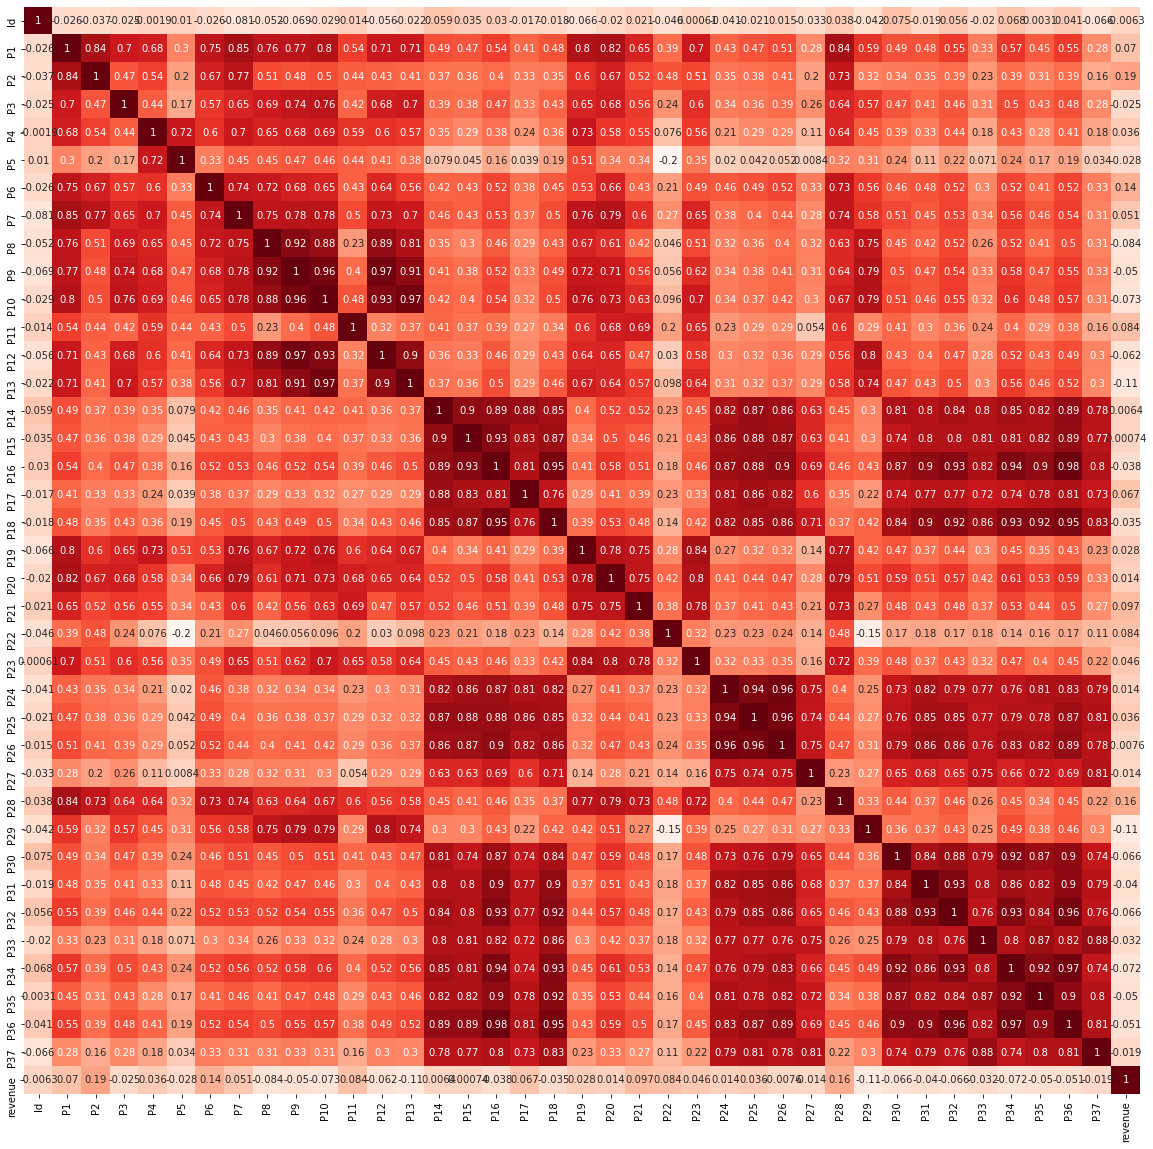

In [9]:
plt.figure(figsize=(20,20))
sns.heatmap(train_df.corr(),annot=True, cbar=False, cmap='Reds')

In [10]:
print_cols()

Index(['Id', 'Open Date', 'City', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4',
       'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15',
       'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35',
       'P36', 'P37', 'revenue'],
      dtype='object')


### Filter out the outliers

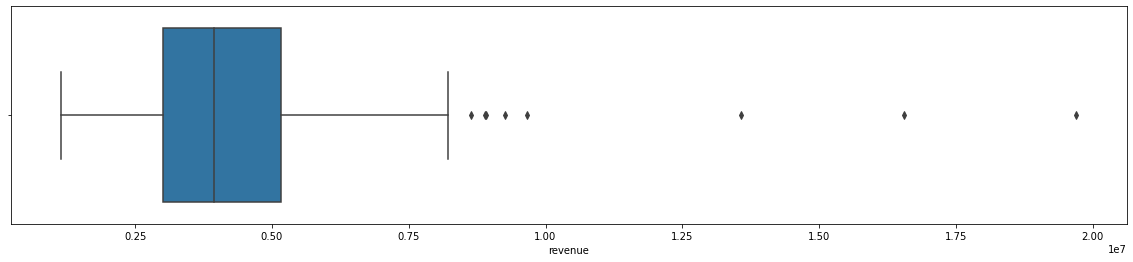

In [11]:
plt.figure(figsize=(20,4))
sns.boxplot(x='revenue',data=train_df)

In [12]:
from scipy.stats import iqr

upper_limit = train_df.revenue.quantile(0.75) + (1.5* iqr(train_df.revenue))
lower_limit = train_df.revenue.quantile(0.25)- (1.5* iqr(train_df.revenue))

condition = (train_df.revenue > upper_limit) | (train_df.revenue<lower_limit)
train_df[condition]

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
16,16,2000-01-07,İstanbul,Big Cities,FC,3,5.0,4.0,4.0,2,...,2.0,0,0,0,0,0,0,0,0,19696939.0
24,24,2009-09-20,İstanbul,Big Cities,IL,5,5.0,3.0,5.0,2,...,2.0,5,5,4,4,4,4,5,2,8904084.0
49,49,2008-04-01,İstanbul,Big Cities,FC,12,7.5,6.0,6.0,2,...,7.5,0,0,0,0,0,0,0,0,8630682.0
75,75,2005-10-15,İstanbul,Big Cities,FC,5,5.0,4.0,5.0,1,...,0.0,0,0,0,0,0,0,0,0,16549064.0
99,99,1999-12-18,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,1.0,5,5,4,2,5,5,5,3,13575224.0
100,100,2007-09-21,İstanbul,Big Cities,FC,3,5.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,9652350.0
116,116,2012-03-30,İzmir,Big Cities,FC,2,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,8894598.0
133,133,2006-10-12,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,9262754.0


- There are eight rows of outlier, the training set is too small, I don't want to drop too many instances.
- Set the threshold higher to 10,000,000.

In [13]:
rev_filter = (train_df.revenue < 10000000)
train_df = train_df[rev_filter]

train_df.shape

(134, 43)

### EDA : restaurant ID

- The id is unique in both training set and testing set, it provide little information, so we will drop it.

In [14]:
len(train_df.Id.unique()) == train_df.shape[0]

True

In [15]:
len(test_df.Id.unique()) == test_df.shape[0]

True

In [16]:
# Drop the ID
train_df.drop('Id',axis=1,inplace=True)
test_df.drop('Id', axis=1, inplace=True)

In [17]:
#check the shape
train_df.shape, test_df.shape

((134, 42), (100000, 41))

### EDA : Open date

In [18]:
train_df['Open Date'].value_counts()

2012-02-02    2
2010-02-23    2
2009-10-16    1
2010-08-23    1
2012-09-09    1
             ..
2011-10-29    1
2008-05-09    1
2010-01-09    1
2009-11-08    1
2012-07-09    1
Name: Open Date, Length: 132, dtype: int64

Divide the open_date column into year, month, day

In [19]:
train_df['open_year'] = train_df['Open Date'].dt.year
# Do it to the test data 
test_df['open_year'] = test_df['Open Date'].dt.year

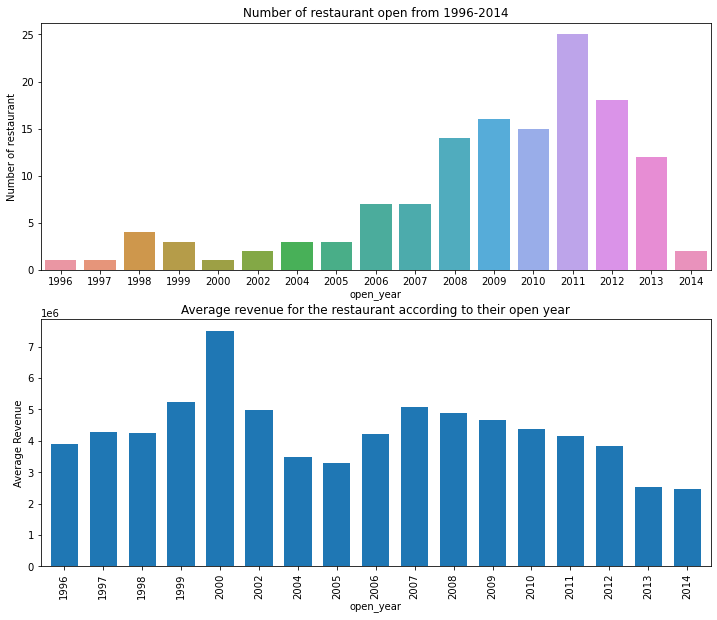

In [20]:
"""
Visualize the data on the graph according the open year

"""

fig = plt.figure(figsize=(12,10))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)

sns.countplot(train_df.open_year,ax=ax1)
ax1.set_title('Number of restaurant open from 1996-2014')
ax1.set_ylabel('Number of restaurant')

train_df.groupby(['open_year']).mean()['revenue'].plot.bar(ax=ax2, width=0.7)
ax2.set_title('Average revenue for the restaurant according to their open year')
ax2.set_ylabel('Average Revenue')

plt.show()

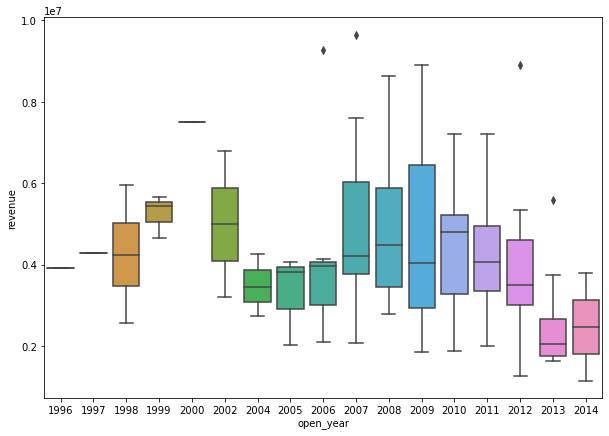

In [21]:
plt.figure(figsize=(10,7))
sns.boxplot(x='open_year',y='revenue', data=train_df)

### EDA: City & City Group
- There are unicode in the names.

In [22]:
train_df['City Group'].value_counts()

Big Cities    75
Other         59
Name: City Group, dtype: int64

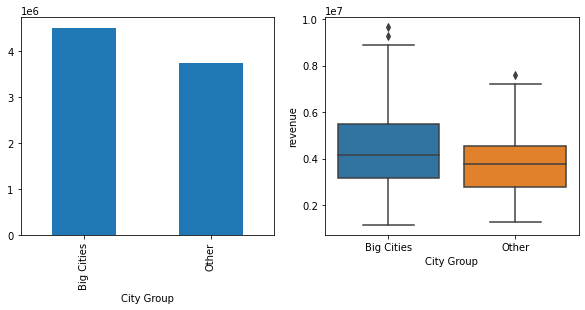

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
train_df.groupby(['City Group']).mean()['revenue'].plot.bar(ax=ax1)
sns.boxplot(x='City Group',y='revenue', data=train_df,ax=ax2)

Plot the average revenue of different cities.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text major ticklabel objects>)

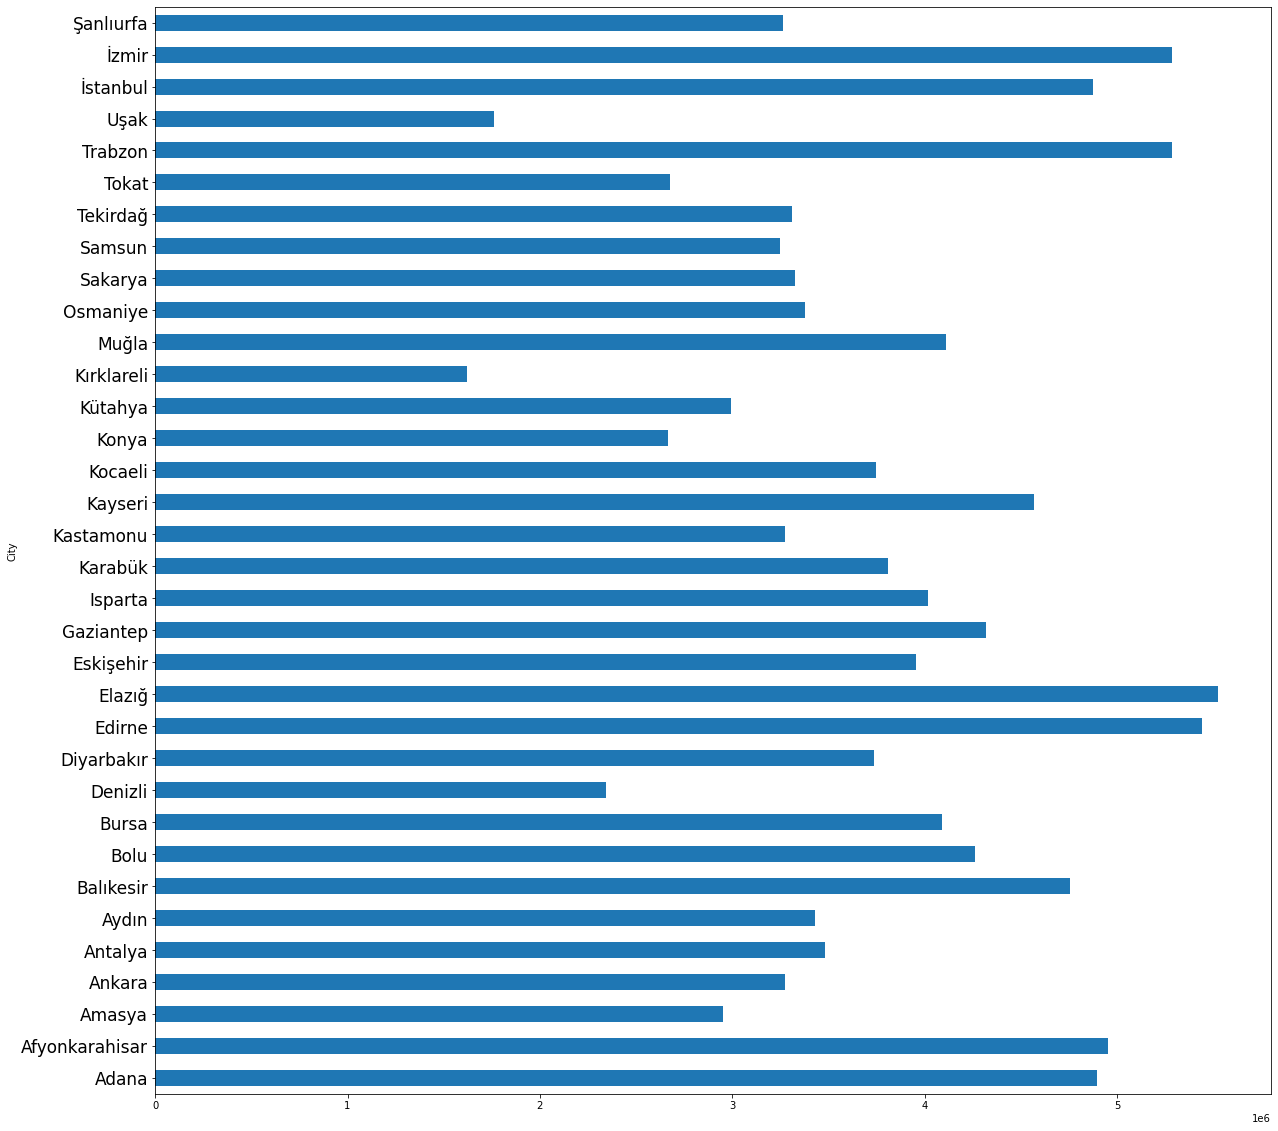

In [24]:
train_df.groupby(['City']).mean()['revenue'].plot.barh(figsize=(20,20))
plt.yticks(fontsize=17)

In [25]:
len(train_df.City.unique()) ,len(test_df.City.unique())

(34, 57)

There are more cities appear in test set than in training set. It provides less information to our model, also, the data of cities appear on the P columns, so I drop the 'city' columns.

In [26]:
train_df.drop('City',axis=1,inplace=True)
test_df.drop('City',axis=1,inplace=True)

### EDA: Type

In [27]:
print_cols()

Index(['Open Date', 'City Group', 'Type', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26',
       'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36',
       'P37', 'revenue', 'open_year'],
      dtype='object')


In [28]:
train_df.Type.value_counts()

FC    74
IL    59
DT     1
Name: Type, dtype: int64

There is only 1 data in 'DT' group, group this data to 'IL'.

In [29]:
train_df.loc[124,'Type'] = 'IL'

#### There is no MB type in training set

In [30]:
test_df.Type.value_counts()

FC    57019
IL    40447
DT     2244
MB      290
Name: Type, dtype: int64

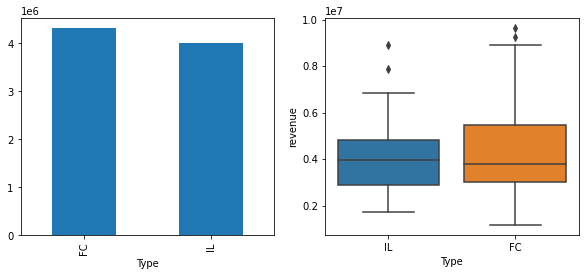

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
train_df.groupby(['Type']).mean()['revenue'].plot.bar(ax=ax1)
sns.boxplot(train_df.Type, train_df.revenue,ax=ax2)
plt.show()

### EDA: p1 , p2 - p37

- There are three categories of these obfuscated data. 
    1. Demographic data, inlcude given area, age and gender.
    2. Real estate data, car park, front facade, m2 of the location.
    3. Commerical main include the existence of points of interest including schools, banks.

In [32]:
train_df.P1.value_counts()

2     36
4     34
3     30
12    12
1      9
6      6
9      4
5      3
Name: P1, dtype: int64

In [33]:
#plt.figure(figsize=(20,25))
#stop = 37
#for i in range(1,stop+1):
    #col_name = 'P' + str(i)
    #plt.subplot(8,5,i)
    #train_df.groupby([col_name]).median()['revenue'].plot.bar(width=0.2)
    #sns.boxplot(col_name, 'revenue',data=train_df, width=0.3)
#plt.show()

The range of all P columns are different.

# Data formatting

In [34]:
train_df.head()

,Open Date,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P30,P31,P32,P33,P34,P35,P36,P37,revenue,open_year
0,1999-07-17,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,5,3,4,5,5,4,3,4,5653753.0,1999
1,2008-02-14,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,0,0,0,0,0,0,0,0,6923131.0,2008
2,2013-03-09,Other,IL,2,4.0,2.0,5.0,2,3,5,...,0,0,0,0,0,0,0,0,2055379.0,2013
3,2012-02-02,Other,IL,6,4.5,6.0,6.0,4,4,10,...,25,12,10,6,18,12,12,6,2675511.0,2012
4,2009-05-09,Other,IL,3,4.0,3.0,4.0,2,2,5,...,5,1,3,2,3,4,3,3,4316715.0,2009


In [35]:
test_df.head()

,Open Date,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,open_year
0,2011-01-22,Other,FC,1,4.0,4.0,4.0,1,2,5,...,3.0,0,0,0,0,0,0,0,0,2011
1,2011-03-18,Other,IL,3,4.0,4.0,4.0,2,2,5,...,3.0,0,0,0,0,0,0,0,0,2011
2,2013-10-30,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,...,3.0,0,0,0,0,0,0,0,0,2013
3,2013-05-06,Other,IL,2,4.0,4.0,4.0,2,3,5,...,3.0,0,4,0,0,0,0,0,0,2013
4,2013-07-31,Other,FC,2,4.0,4.0,4.0,1,2,5,...,3.0,0,0,0,0,0,0,0,0,2013


### Combine training set and test set into complete set for formatting.

In [36]:
comp_df = pd.concat([train_df, test_df])
comp_df.reset_index(drop=True, inplace=True)

### Label encoding: City Group, Type

In [37]:
comp_df.Type.value_counts(),comp_df['City Group'].value_counts()

(FC    57093
 IL    40507
 DT     2244
 MB      290
 Name: Type, dtype: int64,
 Other         50787
 Big Cities    49347
 Name: City Group, dtype: int64)

In [38]:
comp_df.Type = comp_df.Type.map({'MB':0,'DT':1, 'IL':2,'FC':3})
comp_df['City Group'] = comp_df['City Group'].map({'Big Cities':1, 'Other':0})

In [39]:
comp_df.head(3)

,Open Date,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P30,P31,P32,P33,P34,P35,P36,P37,revenue,open_year
0,1999-07-17,1,2,4,5.0,4.0,4.0,2,2,5,...,5,3,4,5,5,4,3,4,5653753.0,1999
1,2008-02-14,1,3,4,5.0,4.0,4.0,1,2,5,...,0,0,0,0,0,0,0,0,6923131.0,2008
2,2013-03-09,0,2,2,4.0,2.0,5.0,2,3,5,...,0,0,0,0,0,0,0,0,2055379.0,2013


### Normalize the p-columns

In [40]:
p_name = ['P'+str(i) for i in range(1,38)]
comp_df[p_name] = MinMaxScaler().fit_transform(comp_df[p_name])

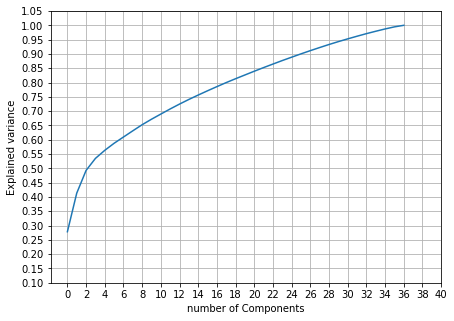

In [41]:
# DPCA to p-columns
from sklearn.decomposition import PCA
pca = PCA().fit(comp_df[p_name])
plt.figure(figsize=(7,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of Components')
plt.ylabel('Explained variance')
plt.yticks(np.arange(0.1,1.1,0.05))
plt.xticks(np.arange(0,41,2))
plt.grid(True)

set n_components to 29.

In [42]:
pca_list = ['pca'+str(i) for i in range(1,30,1)]
comp_df[pca_list] = PCA(n_components=29).fit_transform(comp_df[p_name])
comp_df.drop(p_name,axis=1,inplace=True)

In [43]:
comp_df

,Open Date,City Group,Type,revenue,open_year,pca1,pca2,pca3,pca4,pca5,...,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29
0,1999-07-17,1,2,5653753.0,1999,0.243606,-0.527510,-0.045521,-0.206594,-0.125026,...,-0.037017,0.016193,0.031345,0.059000,0.016255,0.048220,-0.054702,0.029028,0.026632,0.042975
1,2008-02-14,1,3,6923131.0,2008,-0.471515,0.170770,0.177746,-0.226293,-0.126229,...,0.012382,-0.005679,-0.007500,0.028185,-0.009157,-0.021811,0.022046,0.036122,0.031528,0.001586
2,2013-03-09,0,2,2055379.0,2013,-0.597651,0.198493,-0.333930,-0.040836,-0.090928,...,-0.030305,0.052252,-0.007101,-0.063996,-0.037576,0.019852,-0.075007,-0.016819,-0.039074,-0.020373
3,2012-02-02,0,2,2675511.0,2012,2.482674,0.059977,-0.910912,-0.065020,0.209007,...,-0.164486,0.103718,0.204524,-0.020188,0.117540,-0.107868,0.034265,0.003802,-0.079669,0.205567
4,2009-05-09,0,2,4316715.0,2009,-0.009296,-0.450832,-0.315341,-0.238763,-0.087733,...,0.003893,0.033759,0.020665,-0.008124,0.040790,0.154162,0.000591,-0.001348,-0.038915,-0.049402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100129,2000-01-05,0,3,NaN,2000,-0.564011,0.026138,0.264120,0.067066,-0.129262,...,-0.000809,-0.107038,-0.010477,-0.065874,0.054019,-0.052606,0.050158,-0.005580,-0.009870,-0.003340
100130,2011-07-18,0,2,NaN,2011,-0.772675,-0.044185,-0.426603,-0.085292,0.355638,...,0.033197,-0.109380,0.035997,-0.024443,0.009493,-0.027342,0.082202,0.061054,-0.038440,0.029170
100131,2012-12-29,1,2,NaN,2012,0.337268,-0.730569,0.574532,-0.031514,0.149053,...,0.017510,0.043300,-0.057064,0.070481,-0.060259,0.081257,0.016498,-0.029885,-0.022418,0.005533
100132,2013-10-12,1,3,NaN,2013,1.344066,1.422243,0.143795,-0.202669,-0.163206,...,0.056199,-0.021769,0.003462,0.032151,-0.146600,-0.144739,-0.049876,-0.174633,-0.069845,-0.027478


### Normalize the date
- Create new column 'launch days'
- Normalize open_year, launch days

In [44]:
import datetime
comp_df['launch_days'] = (datetime.datetime.now() - comp_df[['Open Date']])
comp_df['launch_days'] = comp_df['launch_days'].dt.days

In [45]:
comp_df.drop('Open Date',axis=1,inplace=True)

In [46]:
comp_df['launch_days'] = MinMaxScaler().fit_transform(comp_df[['launch_days']])
comp_df['open_year'] = MinMaxScaler().fit_transform(comp_df[['open_year']])

# Split to training set and test set

In [47]:
test_df = comp_df[comp_df['revenue'].isnull()]
train_df = comp_df[comp_df['revenue'].notnull()]
test_df.drop('revenue',axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
train_df.shape, test_df.shape

((134, 34), (100000, 33))

In [49]:
x_train = train_df.drop('revenue',axis=1)
y_train = train_df['revenue']

# Start training model

- LGBMRegressor()

In [50]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, RepeatedKFold

### Train without tuning

In [51]:
cv = RepeatedKFold(n_splits=10, n_repeats=3)
scores = cross_validate(LGBMRegressor(), x_train,y_train, scoring=['r2','neg_root_mean_squared_error'],cv=cv)

In [52]:
r2 = scores['test_r2']
rmse = scores['test_neg_root_mean_squared_error']
print(np.mean(r2),np.mean(rmse))

-0.16615385797221624 -1723304.426077097


# Hyperparameters tuning

### LGBM regressor

In [53]:
# random forest first
#cv = RepeatedKFold(n_splits=10, n_repeats=3)
#params = {
    #'n_estimators':[20,50,100,200],
    #'max_depth':[3,5,7],
    #'learning_rate':[0.0001,0.001,0.01,0.1,1],
    #'boosting_type':['gbdt','dart','goss'],
    #'subsample':[0.3,0.5,0.7,1]
#}

#lgbm_grid = GridSearchCV(LGBMRegressor(random_state=42),params, cv=cv, verbose=1, n_jobs=-1,scoring='neg_root_mean_squared_error')
#lgbm_grid.fit(x_train,y_train)

# Prediction on test data
- And output the file

In [54]:
final_model = LGBMRegressor(boosting_type='dart',max_depth=3,n_estimators=20,random_state=42, subsample=0.3).fit(x_train,y_train)

In [55]:
test_file = pd.read_csv('../input/restaurant-revenue-prediction/test.csv.zip')
answer = pd.DataFrame(final_model.predict(test_df))
answer.columns = ['Prediction']
answer['Id'] = test_file.index.tolist()
answer.set_index('Id',inplace=True)

In [56]:
answer.to_csv('result.csv')